In [116]:
#Librerías necesarias
import cv2
from matplotlib import pyplot as plt
import math
import numpy as np


(341, 256, 3)
(341, 256, 3)
(341, 256, 3)
(341, 256, 3)
(341, 256, 3)
(341, 256, 3)
(341, 256, 3)
(341, 256, 3)
(341, 256, 3)
(341, 256, 3)
(341, 256, 3)
(341, 256, 3)
(341, 256, 3)
(341, 256, 3)
(341, 256, 3)
(341, 256, 3)
(341, 256, 3)
(341, 256, 3)
(341, 256, 3)
(341, 256, 3)
(341, 256, 3)
(341, 256, 3)
(341, 256, 3)
(341, 256, 3)
(341, 256, 3)
(341, 256, 3)
(341, 256, 3)
(341, 256, 3)
(341, 256, 3)
(341, 256, 3)


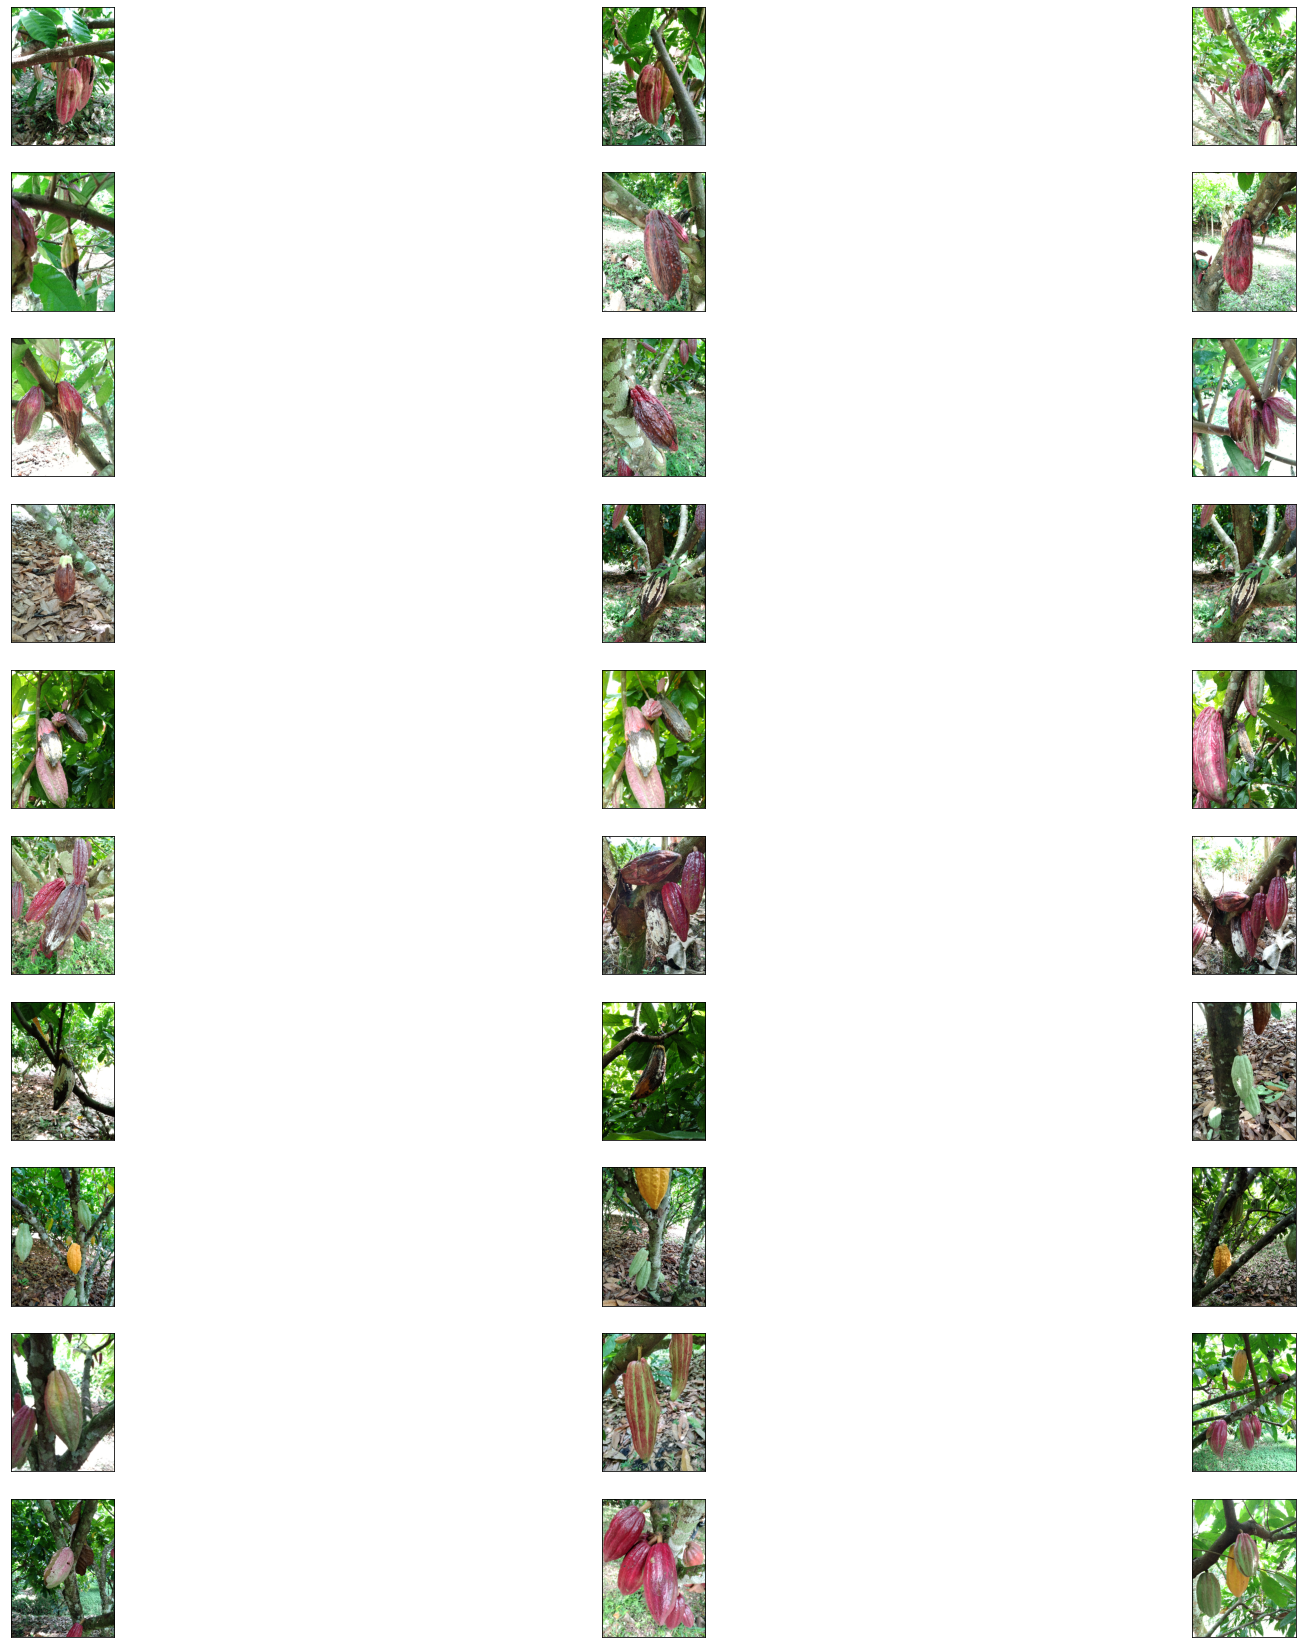

In [117]:
# Importacion de imagenes

# path
#ruta='../../figs/imgsReto/'
ruta='../../figs/baseDatos/'

# Pixeles del mínimo entre el ancho y el alto
minSize=256


# Importación de monilia
n_imag_monilia=10
imag_monilia=[]

for i in range(n_imag_monilia):
    imag_aux = cv2.imread(f'{ruta}Monilia/Monilia{i+1}.jpg')
    imag_aux=cv2.cvtColor(imag_aux,cv2.COLOR_BGR2RGB)
    
    n=imag_aux.shape[0]
    m=imag_aux.shape[1]

    escala= minSize/min(n,m)
    imag_aux= cv2.resize(imag_aux, None, fx=escala, fy= escala,\
                                interpolation= cv2.INTER_LINEAR)

    imag_monilia.append(imag_aux)


# Importacion de Phytophthora 

n_imag_fito=10
imag_fito=[]

for i in range(n_imag_fito):
    imag_aux = cv2.imread(f'{ruta}Fito/Fito{i+1}.jpg')
    imag_aux=cv2.cvtColor(imag_aux,cv2.COLOR_BGR2RGB)
    
    n=imag_aux.shape[0]
    m=imag_aux.shape[1]

    escala= minSize/min(n,m)
    imag_aux= cv2.resize(imag_aux, None, fx=escala, fy= escala,\
                                interpolation= cv2.INTER_LINEAR)


    imag_fito.append(imag_aux)
    

# Importación de cacao saludable

n_imag_healty=10
imag_healty=[]

favory_healty=range(n_imag_healty)

for i in favory_healty:
    imag_aux = cv2.imread(f'{ruta}Sana/Sana{i+1}.jpg')

    imag_aux=cv2.cvtColor(imag_aux,cv2.COLOR_BGR2RGB)
    
    n=imag_aux.shape[0]
    m=imag_aux.shape[1]

    escala= minSize/min(n,m)
    imag_aux= cv2.resize(imag_aux, None, fx=escala, fy= escala,\
                                interpolation= cv2.INTER_LINEAR)

    imag_healty.append(imag_aux)
    
## Se unen todas las imágenes y se haca un redimensionamiento
imagenes = imag_fito+imag_monilia+imag_healty


plt.figure(figsize=(30, 30))
for i in range(len(imagenes)):
    print(imagenes[i].shape)
    plt.subplot(math.ceil(len(imagenes)/3),3,i+1),plt.imshow(imagenes[i])
    plt.xticks([]),plt.yticks([])

plt.show()


El procedimiento general para hacer la segmentación por medio de color se toma de [Maindola2021]

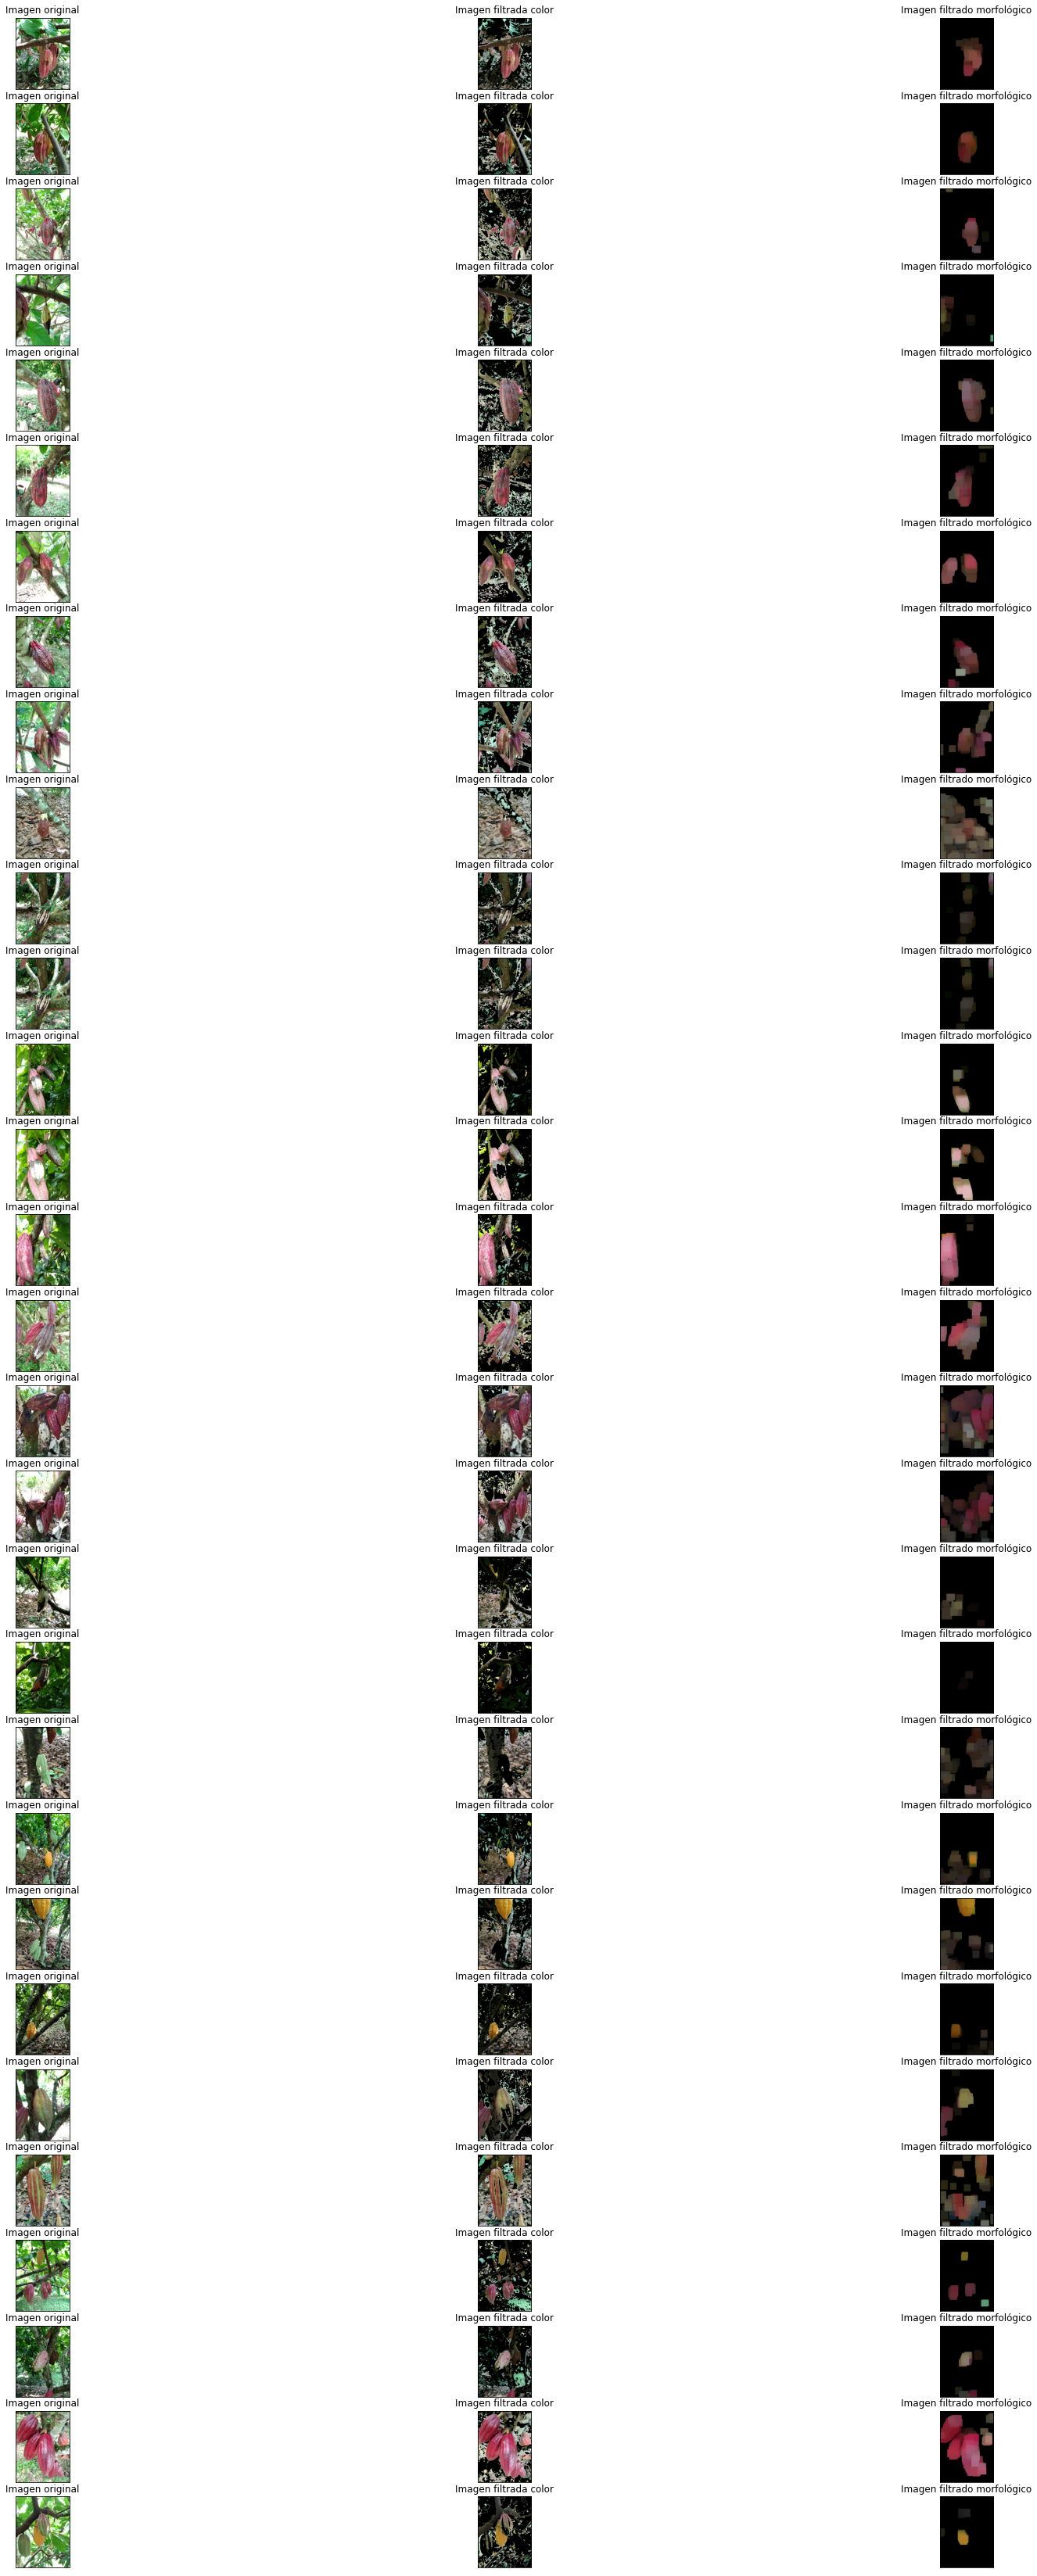

In [118]:
## Preprocesamiento
def filtroErosionesDilataciones(img,n_erosiones,n_dilataciones):
    ''' 
    img: Imagen en RGB
    n_erosiones: Número de erosiones
    n_dilataciones: Número de dilataciones

    '''
    elemento_rectangular = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
    kernel=elemento_rectangular
    
    opening = cv2.morphologyEx(img,cv2.MORPH_OPEN,kernel, iterations = 1)
    closing= cv2.morphologyEx(opening,cv2.MORPH_CLOSE,kernel, iterations = 1)

    
    
    img_erosion= cv2.erode(closing,kernel,iterations = n_erosiones)

    img_erosion_dilatacion=cv2.dilate(img_erosion,kernel,\
    iterations = n_dilataciones)

    return img_erosion_dilatacion

def filtroApertura(img,n_aperturas):
    ''' 
    img: Imagen en RGB
    n_aperturas: Número de Aperturas
    '''
    elemento_rectangular = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
    kernel=elemento_rectangular
    
    opening = cv2.morphologyEx(img,cv2.MORPH_OPEN,kernel, iterations = 1)
    closing= cv2.morphologyEx(opening,cv2.MORPH_CLOSE,kernel, iterations = 1)

    opening = cv2.morphologyEx(closing,cv2.MORPH_OPEN,kernel, iterations = n_aperturas)
    return opening

def filtroCierre(img,n_cierres):
    ''' 
    img: Imagen en RGB
    n_cierres: Número de Cierres
    '''
    elemento_rectangular = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
    kernel=elemento_rectangular
    
    opening = cv2.morphologyEx(img,cv2.MORPH_OPEN,kernel, iterations = 1)
    closing= cv2.morphologyEx(opening,cv2.MORPH_CLOSE,kernel, iterations = 1)

    closing = cv2.morphologyEx(closing,cv2.MORPH_CLOSE,kernel, iterations = n_cierres)
    return closing

def filtradoEnColor(image_blur):
    # Rango de color para eliminar el verde
    light_green = (40, 40, 40)
    dark_green = (70, 255, 255)

    # Rango de color para eliminar la luz [rrr2]

    light_white = (0, 0, 231)
    dark_white = (180, 18, 255)

    # Filtrado en verde
    # conversion a HSV (matiz, saturación, valor)
    image_blur_HSV= cv2.cvtColor(image_blur, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(image_blur_HSV, light_green, dark_green)
    result = cv2.bitwise_and(image_blur, image_blur, mask=mask)
    resultadoSinVerde=cv2.subtract(image_blur,result)

    # Filtrado en blanco
    mask = cv2.inRange(image_blur_HSV, light_white, dark_white)
    result = cv2.bitwise_and(image_blur, image_blur, mask=mask)
    resultadoSinBlanco=cv2.subtract(resultadoSinVerde,result)

    return resultadoSinBlanco

image_blur = []
image_colorFilter= []
image_filter=[]



for i in range(len(imagenes)):
    # Filtro GaussianBlur
    image_blur.append(cv2.GaussianBlur(imagenes[i],(5,5),0))
    

    image_colorFilter.append(filtradoEnColor(image_blur[i]))
    # n_erosiones=math.ceil(math.log(closing.shape[0]*closing.shape[1]))
    # n_erosiones=7
    # n_dilataciones=7
    n_aperturas=15
    # n_cierres=15
  

    
    #image_filter.append(filtroErosionesDilataciones(image_colorFilter[i],\
    #    n_erosiones,n_dilataciones))

    image_filter.append(filtroApertura(image_colorFilter[i],n_aperturas))
    #image_filter.append(filtroCierre(image_colorFilter[i],n_cierres))


plt.figure(figsize=(30,60))
contador=0
for i in range(0,len(imagenes)*3,3):
    plt.subplot(len(imagenes),3,i+1),plt.imshow(imagenes[contador])
    plt.title('Imagen original'),plt.xticks([]),plt.yticks([])

    plt.subplot(len(imagenes),3,i+2),plt.imshow(image_colorFilter[contador])
    plt.title('Imagen filtrada color'),plt.xticks([]),plt.yticks([])

    plt.subplot(len(imagenes),3,i+3),plt.imshow(image_filter[contador])
    plt.title('Imagen filtrado morfológico'),plt.xticks([]),plt.yticks([])

    contador+=1
contador=0
plt.show()

In [119]:
# Contornos y áreas
def posMax(Vector):
    ''' 
    Calcula la posición del máximo componete del Vector
    Vector: nx1 vector para hallar el máximo
    '''
    return np.where(Vector == np.amax(Vector))[0][0]


def myThreshold(img_rbg):
    # Conversión a escala de grises
    gray=cv2.cvtColor(img_rbg, cv2.COLOR_RGB2GRAY) 

    # Umbralización 'adaptativa' con THRESH_OTSU
    # img_thr_THRESH_OTSU= cv2.threshold(img_gray_blur[i],0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
    # Umbralización con threshold
    
    return cv2.threshold(gray,3,255,0)[1] 

def unosDentroMascara(mask,cnt):
    # https://stackoverflow.com/questions/50670326/how-to-check-if-point-is-placed-inside-contour
    # https://docs.opencv.org/4.5.5/dc/d48/tutorial_point_polygon_test.html
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            dist = cv2.pointPolygonTest(cnt,(j,i),False)
            if dist>=0:
                mask[i,j]=1

    return mask

    

lisContours=[]
image_minAreaRect=[]
image_umbralizada=[]
#image_mascaras=[]
image_segmentada=[]

for i in range(len(imagenes)):

    image_umbralizada.append(myThreshold(image_filter[i]))
    lisContours.append(cv2.findContours(\
            image_umbralizada[i],cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[0])
    image_minAreaRect.append(imagenes[i].copy())
    # https://docs.opencv.org/4.5.5/dd/d49/tutorial_py_contour_features.html
    # https://docs.opencv.org/4.5.5/d6/d6e/group__imgproc__draw.html#ga57be400d8eff22fb946ae90c8e7441f9

    
    
    areas=np.array([],float)
    for contorno in lisContours[i]:        
        areas=np.append(areas,cv2.contourArea(contorno))

    ## Se elige la máxima área
  
    try:
        posicionMaximaArea=posMax(areas)
    except ValueError: 
        posicionMaximaArea=0


    rect = cv2.minAreaRect(lisContours[i][posicionMaximaArea])
    box = cv2.boxPoints(rect)
    box = np.int0(box)


    cv2.drawContours(image_minAreaRect[i], contours=[box],\
    contourIdx=-1, color=(0, 0, 255), thickness=2, lineType=cv2.LINE_AA)

    
    ellipse = cv2.fitEllipse(lisContours[i][posicionMaximaArea])
    cv2.ellipse(img=image_minAreaRect[i],box=ellipse,color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)
    
    #https://itecnote.com/tecnote/python-get-mask-from-contour-with-opencv/
    
    # Se realiza la máscara
    n=image_minAreaRect[i].shape[0]
    m=image_minAreaRect[i].shape[1]
    # image_mascaras.append(np.zeros((n,m), np.uint8))
    # image_mascaras[i]=unosDentroMascara(image_mascaras[i],box)

    mask=np.zeros((n,m), np.uint8)
    mask=unosDentroMascara(mask,box)


    #cv2.ellipse(img=image_mascaras[i],box=ellipse,color=(255), thickness=2, lineType=cv2.LINE_AA)
    
    # cv2.drawContours(image_minAreaRect[i], contours=[box],\
    # contourIdx=0, color=(0, 0, 255), thickness=2, lineType=cv2.LINE_AA)

    # Se discrimina el área de interés
    auxImagenSegmentada=cv2.bitwise_and(image_blur[i], image_blur[i], mask=mask)
    #auxImagenSegmentada=filtradoEnColor(auxImagenSegmentada)
    #auxImagenSegmentada=filtroApertura(auxImagenSegmentada,3)
    image_segmentada.append(auxImagenSegmentada) 


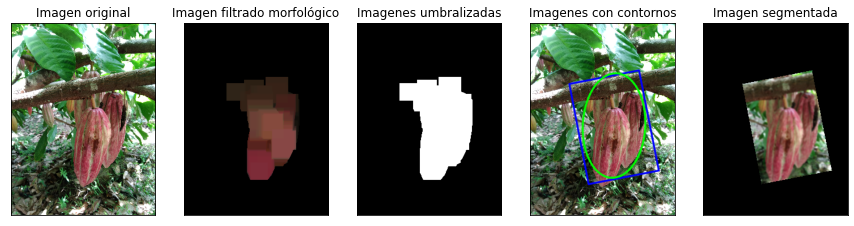

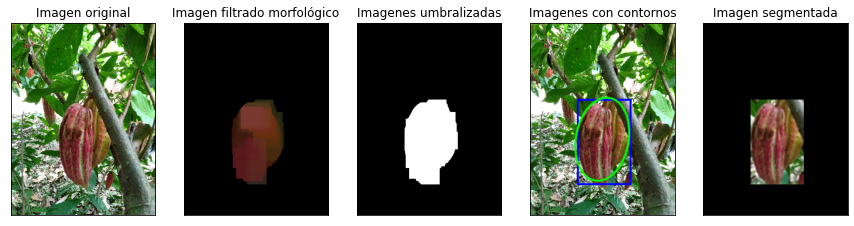

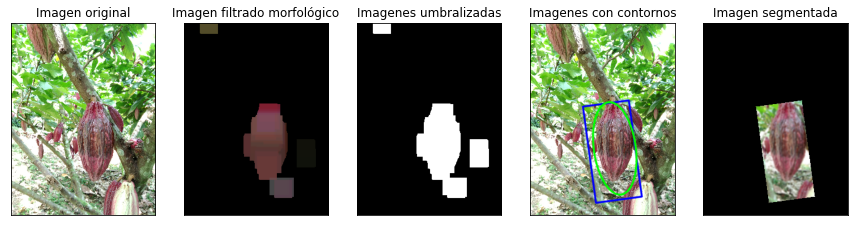

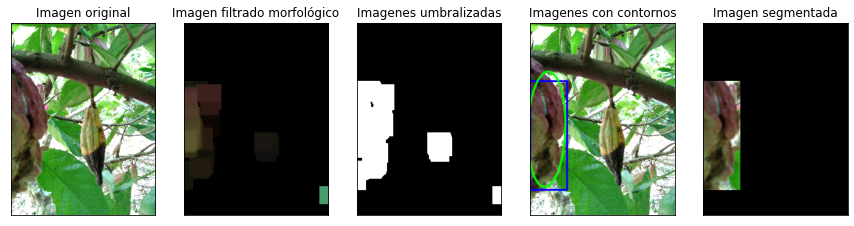

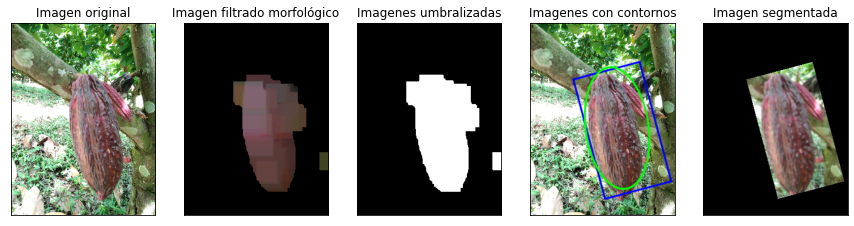

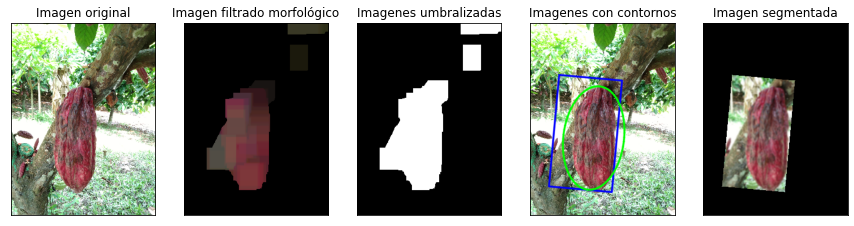

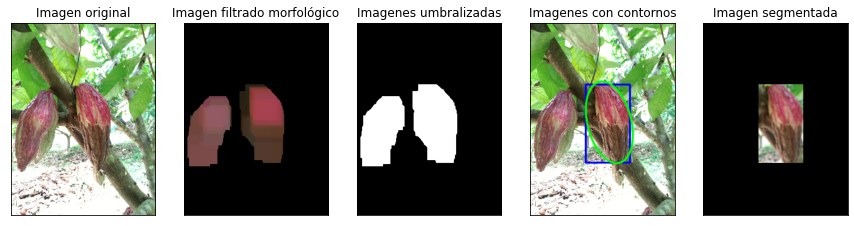

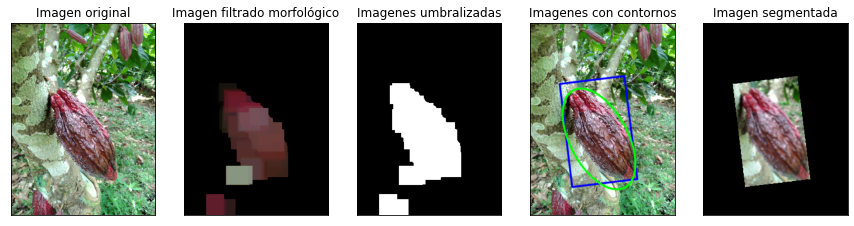

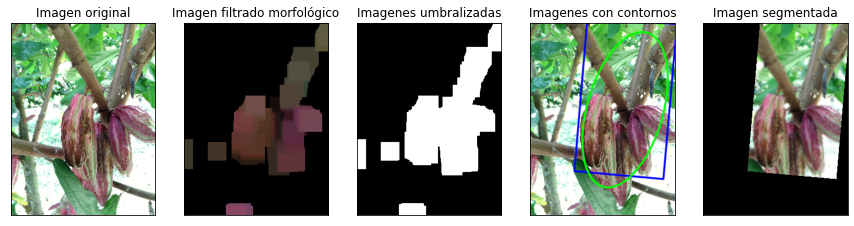

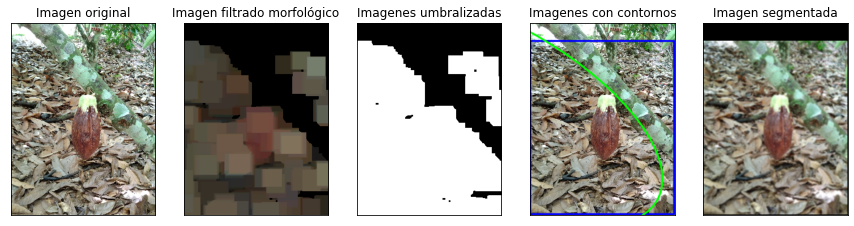

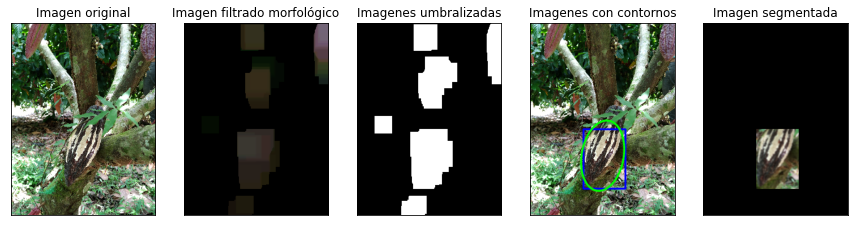

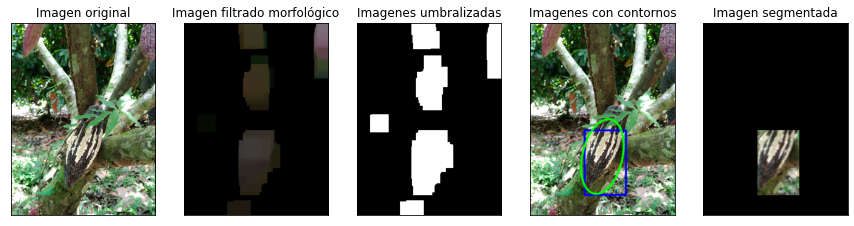

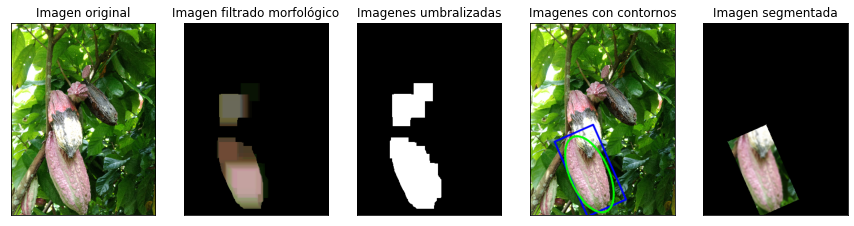

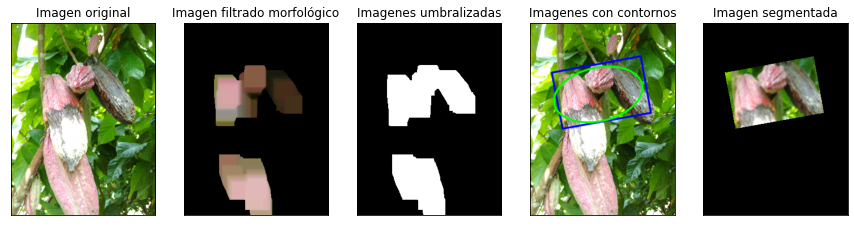

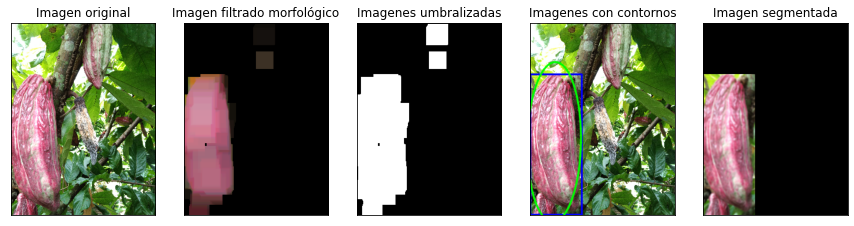

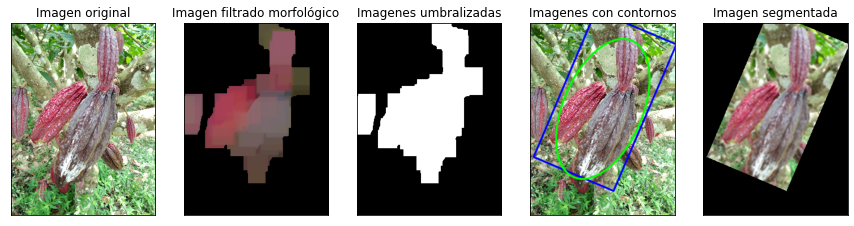

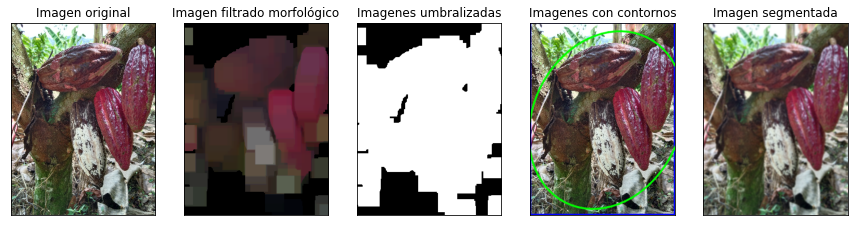

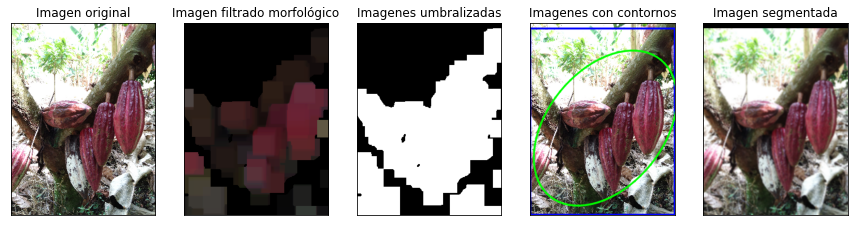

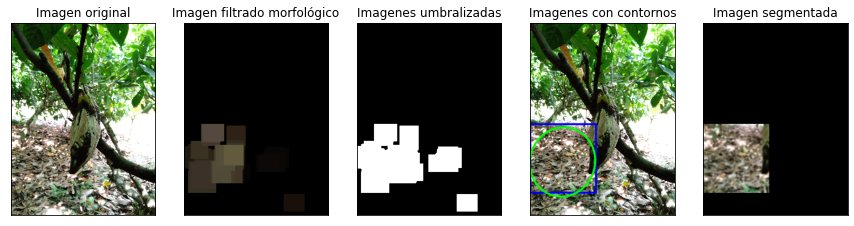

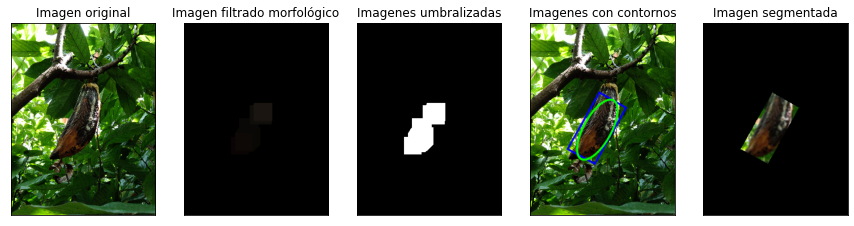

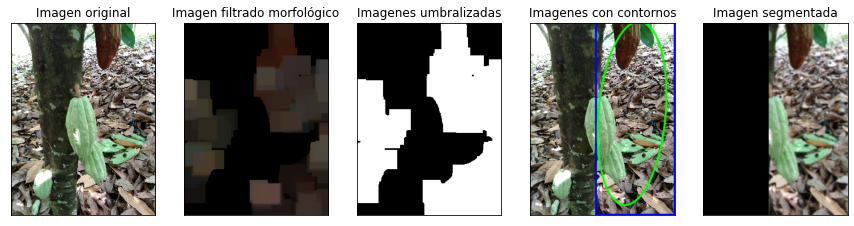

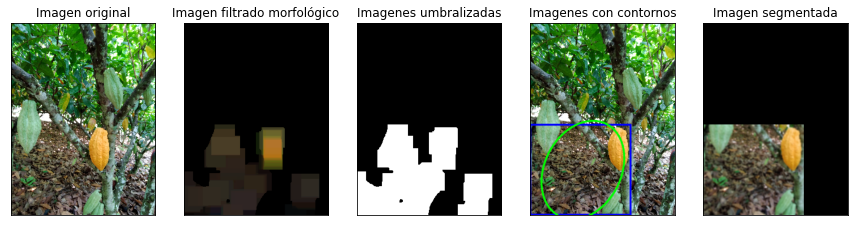

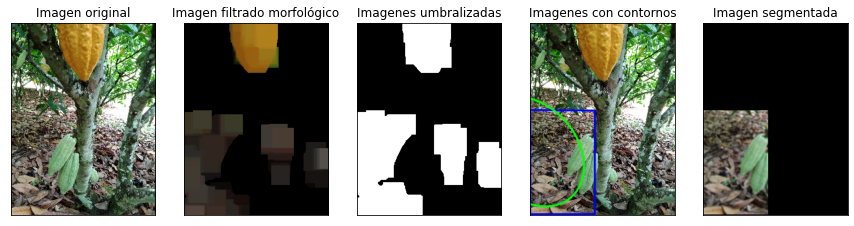

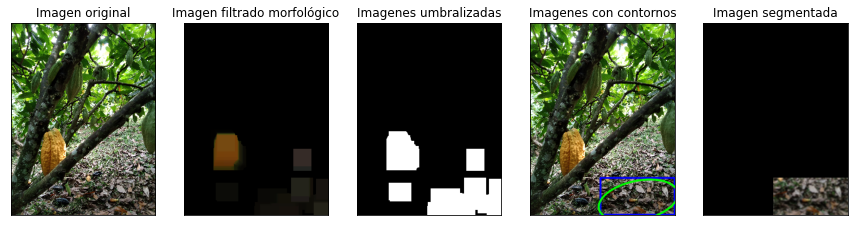

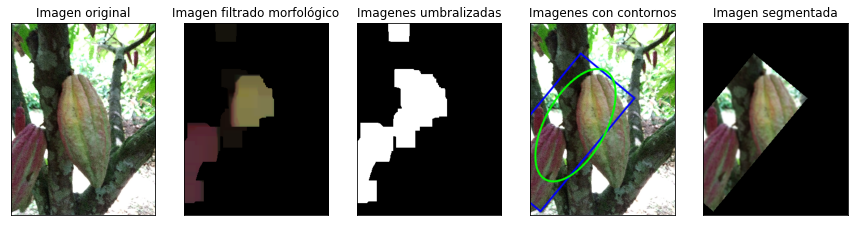

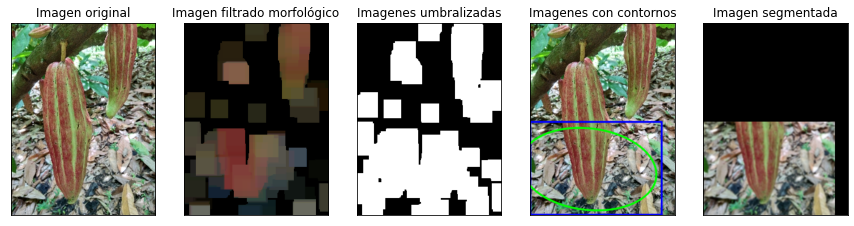

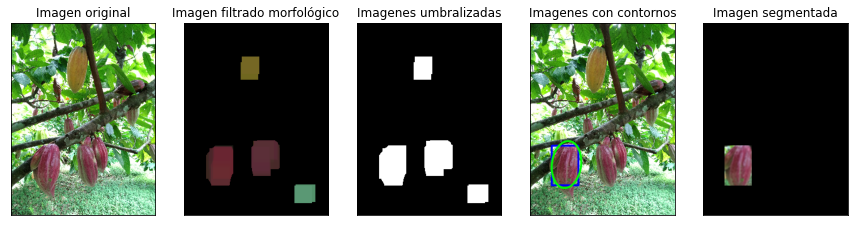

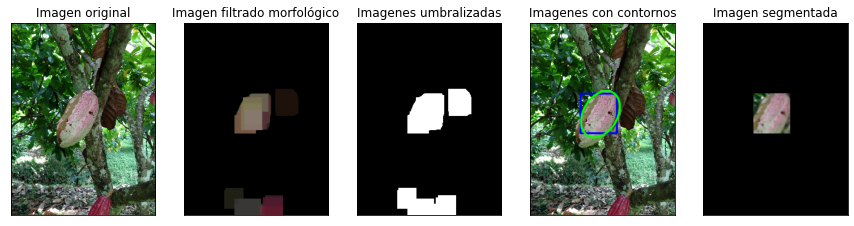

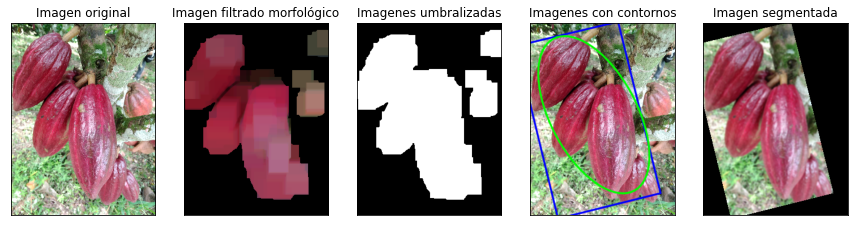

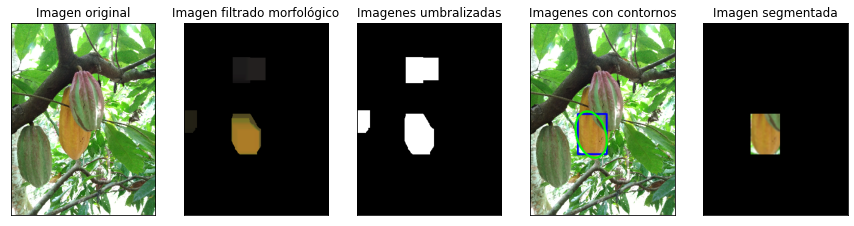

In [120]:

contador=0
n_imagenes=len(imagenes)


for i in range(n_imagenes):
    plt.figure(figsize=(15,15))
    plt.subplot(1,5,1),plt.imshow(imagenes[i])
    plt.title('Imagen original'),plt.xticks([]),plt.yticks([])


    plt.subplot(1,5,2),plt.imshow(image_filter[i])
    plt.title('Imagen filtrado morfológico'),plt.xticks([]),plt.yticks([])

    plt.subplot(1,5,3),plt.imshow(image_umbralizada[i],cmap = 'gray')
    plt.title('Imagenes umbralizadas'),plt.xticks([]),plt.yticks([])

    plt.subplot(1,5,4),plt.imshow(image_minAreaRect[i])
    plt.title('Imagenes con contornos'),plt.xticks([]),plt.yticks([])


    plt.subplot(1,5,5),plt.imshow(image_segmentada[i])
    plt.title('Imagen segmentada'),plt.xticks([]),plt.yticks([])
    # plt.savefig(f"resultados/fig{contador+1}.pdf", dpi=150)
    plt.show()




## Referencias

